Here we compare statistics for significant coefficients of linear models fit to Keller/Zlatic VNC data (A00c, basin or handle cells) computed with three different methods. 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import copy
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import scipy.io

from keller_zlatic_vnc.data_processing import extract_transitions
from keller_zlatic_vnc.data_processing import generate_transition_dff_table
from keller_zlatic_vnc.data_processing import read_raw_transitions_from_excel
from keller_zlatic_vnc.data_processing import recode_beh
from keller_zlatic_vnc.linear_modeling import one_hot_from_table
from keller_zlatic_vnc.linear_modeling import reference_one_hot_to_beh

from janelia_core.stats.regression import grouped_linear_regression_boot_strap
from janelia_core.stats.regression import grouped_linear_regression_boot_strap_stats
from janelia_core.stats.regression import grouped_linear_regression_wild_bootstrap
from janelia_core.stats.regression import grouped_linear_regression_within_estimator
from janelia_core.stats.regression import grouped_linear_regression_within_estimator_stats

/Users/williambishop/Documents/Janelia_Research/Projects/janelia_core/janelia_core/fileio/exp_reader.py:21: UserWarning: Unable to locate pyklb module.  Will not be able to read in .klb files.
  warnings.warn('Unable to locate pyklb module.  Will not be able to read in .klb files.')


## Parameters go here

#### Location of data

In [3]:
data_folder = r'/Volumes/bishoplab/projects/keller_vnc/data/extracted_dff_v2'
transition_file = 'transition_list.xlsx'

a00c_a4_act_data_file = 'A00c_activity_A4.mat'
a00c_a9_act_data_file = 'A00c_activity_A9.mat'

#### Options for analysis

In [4]:
# Type of cells we fit models to
cell_type = 'a00c' 

# If we fit data to perturbations targeted at 'A4', 'A9' or 'both'
manip_type = 'A4' 

# Define the cutoff time we use to define quiet behaviors following stimulation
cut_off_time = np.inf

# Specify if we predict dff 'before' or 'after' the manipulation
period = 'before'

# Specify variables that we predict from
beh_before = ['Q', 'F', 'B']
beh_after = ['Q', 'F', 'B']
beh_reference = 'Q'

enc_beh_interactions = False
closure = True # True if the only events we consider must start with a before_beh 
               # behavior and end with an beh_after behavior
    
# Specify number of bootstrap samples we perform with bootstrap methods
n_bs_smps = 1000

## Specify some parameters we use in the code below

In [5]:
if cell_type == 'a00c':
    a4_act_file = a00c_a4_act_data_file
    a9_act_file = a00c_a9_act_data_file
else:
    raise(ValueError('The cell type ' + cell_type + ' is not recogonized.'))

## Load data

In [6]:
# Read in raw transitions
raw_trans = read_raw_transitions_from_excel(pathlib.Path(data_folder) / transition_file)

# Read in activity
a4_act = scipy.io.loadmat(pathlib.Path(data_folder) / a4_act_file, squeeze_me=True)
a9_act = scipy.io.loadmat(pathlib.Path(data_folder) / a9_act_file, squeeze_me=True)

# Recode behavioral annotations
raw_trans = recode_beh(raw_trans, 'Beh Before')
raw_trans = recode_beh(raw_trans, 'Beh After')

# Extract transitions
trans = extract_transitions(raw_trans, cut_off_time)

# Generate table of data 
a4table = generate_transition_dff_table(act_data=a4_act, trans=trans)
a9table = generate_transition_dff_table(act_data=a9_act, trans=trans)

# Put the tables together
a4table['man_tgt'] = 'A4'
a9table['man_tgt'] = 'A9'
data = a4table.append(a9table, ignore_index=True)

## Down select to only the manipulation events we want to consider

In [7]:
if manip_type == 'A4':
    print('Analyzing only A4 manipulation events.')
    data = data[data['man_tgt'] == 'A4']
elif manip_type == 'A9':
    print('Analyzing only A9 manipulation events.')
    data = data[data['man_tgt'] == 'A9']
else:
    print('Analyzing all manipulation events.')

Analyzing only A4 manipulation events.


## Enforce closure if needed

In [8]:
if closure:
    print('Enforcing closure.')
    before_closure = np.asarray([b in set(beh_before) for b in data['beh_before']], 
                                dtype=bool)
    after_closure = np.asarray([b in set(beh_after) for b in data['beh_after']], 
                                dtype=bool)
    closure = np.logical_and(before_closure, after_closure)
    
    data = data[closure]

Enforcing closure.


## Get rid of rows of data that have no behavior of interest

In [9]:
before_ignore = np.asarray([b not in set(beh_before) for b in data['beh_before']], 
                                dtype=bool)
after_ignore = np.asarray([b not in set(beh_after) for b in data['beh_after']], 
                                dtype=bool)

ignore_rows = np.logical_and(before_ignore, after_ignore)

data = data[np.logical_not(ignore_rows)]

## Get groups of data (a group corresponds to each subject)

In [10]:
unique_ids = data['subject_id'].unique()
g = np.zeros(len(data))
for u_i, u_id in enumerate(unique_ids):
    g[data['subject_id'] == u_id] = u_i

## Pull out $\Delta F / F$

In [11]:
if period == 'before':
    dff = data['dff_before'].to_numpy()
elif period == 'after':
    dff = data['dff_after'].to_numpy()
else:
    raise(ValueError('The period ' + ' period is not recogonized.'))

## Get dummy variable representation of the data

In [12]:
one_hot_data, one_hot_vars = one_hot_from_table(data, 
                                                beh_before=beh_before, 
                                                beh_after=beh_after,
                                                enc_subjects=True, 
                                                enc_beh_interactions=enc_beh_interactions)

n_subjects = len(unique_ids)
one_hot_data_wo_subjs = one_hot_data[:, 0:-n_subjects]

#### Reference one hot data to requested behavior

In [13]:
one_hot_data_ref, one_hot_vars_ref = reference_one_hot_to_beh(one_hot_data=one_hot_data, 
                                                              one_hot_vars=one_hot_vars,
                                                              beh=beh_reference)

#### Get version of one hot data without subjects

In [14]:
one_hot_data_ref_wo_subjs = copy.deepcopy(one_hot_data_ref)
one_hot_data_ref_wo_subjs = one_hot_data_ref_wo_subjs[:, 0:-n_subjects]

## Get stats with different methods

#### Pairs bootstrap

In [15]:
pairs_bs_results = grouped_linear_regression_boot_strap(x=one_hot_data_ref, 
                                                        y=dff, 
                                                        g=g, 
                                                        n_bs_smps=n_bs_smps, 
                                                        include_mean=False)

pairs_bs_stats = grouped_linear_regression_boot_strap_stats(pairs_bs_results[0])

#### Wild bootstap

In [16]:
wild_bs_stats = grouped_linear_regression_wild_bootstrap(x=one_hot_data_ref_wo_subjs,
                                                         y=dff,
                                                         g=g,
                                                         n_bs_smps=n_bs_smps)

In [17]:
wild_bs_stats

array([0.514, 0.626, 0.31 , 0.453])

## Within estimator

In [25]:
(within_estimator_beta, 
 within_estimator_avm, 
 within_estimator_offsets, 
 within_estimator_n_gprs) = grouped_linear_regression_within_estimator(x=one_hot_data_ref_wo_subjs, 
                                                                       y=dff, g=g)

In [36]:
within_estimator_stats = grouped_linear_regression_within_estimator_stats(beta=within_estimator_beta,
                                                                          avm=within_estimator_avm,
                                                                          n_grps=within_estimator_n_gprs,
                                                                          alpha=.05)

In [37]:
within_estimator_stats

{'alpha': 0.05,
 'c_ints': array([[ 0.02797476,  0.02507035, -0.00090862, -0.01027774],
        [ 0.02797476,  0.02507035,  0.00391376, -0.00016166]]),
 'non_zero_p': array([0.        , 0.        , 0.21480716, 0.04344837]),
 'non_zero': array([ True,  True, False,  True])}

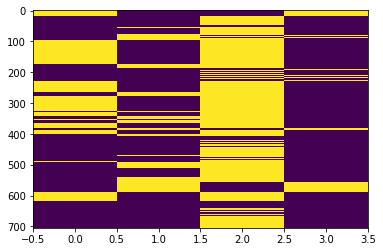

In [42]:
plt.imshow(one_hot_data_ref_wo_subjs, aspect='auto')

In [43]:
_, s, _ = np.linalg.svd(one_hot_data_ref_wo_subjs)

In [44]:
s

array([26.38219272, 13.70541401, 10.36404588,  5.72084671])